### Neshyba 2023


# Particle-on-a-sphere

## Introduction

We've already seen, in studying oxygenated graphene, how to construct a Hamiltonian matrix for a system with two degrees of freedom. Now we're going to try our hand at three degrees! The Schrödinger equation, of course, is given by its usual

$$
H\psi=E\psi \ \ \ \ (1)
$$

For a particle that can move in three dimensions, we could write $H$ a little more explicitly as

$$
H = PE(x,y,z) + {-\hbar^2 \over 2 m} \nabla^2 \ \ \ \ (2)
$$

In this exercise, we'll be looking at the behavior of an electron that is more or less confined to the surface of a sphere (details below). 

Now, you might make the following objection at this point: if our electron is confined to a *surface*, it's really a 2-d problem, not a 3-d problem. And that's true! But by setting things up this way, we're hoping to get some insight into that kind of problem when we get to it.


## Matrix representation of the the kinetic energy operator in 3-d
Similarly to what we did before, our strategy is to use Kronecker delta functions to start with a kinetic energy matrix for a particle moving in a single, to a 3-d *outer product*. In terms of Python code, that strategy looks like this:

    KEx = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(nx))+np.diag(np.ones(nx-1),1)+np.diag(np.ones(nx-1),-1))/dx**2
    KEy = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(ny))+np.diag(np.ones(ny-1),1)+np.diag(np.ones(ny-1),-1))/dy**2
    KEz = -hbar**2/(2*m) * (-2.0*np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)+np.diag(np.ones(nz-1),-1))/dz**2

We'll also need three identity matrices,

    Ix = np.diag(np.ones(nx))
    Iy = np.diag(np.ones(ny))
    Iz = np.diag(np.ones(nz))

Then we'll combine them using a Kronecker delta function,

    KE = kron3(KEx,Iy,Iz) + kron3(Ix,KEy,Iz) + kron3(Ix,Iy,KEz)
    
where kron3 is a 3d generalization of Numpy's kron2 function. You'll making your own kron3 here, actually -- for background, you can have a look at https://math.stackexchange.com/questions/3120948/discretization-matrix-for-3d-poisson-equation.

This strategy is easy enough to code up, which is why we're adopting it here. A big limitation of the approach, however, is that the resulting outer product gets big fast. For example, a 1-d discretization of merely 15 points in each Cartesian direction (i.e., $n_x=n_y=n_z=15$) means an outer product of $15 \times 15 \times 15 = 3375$. That is, the corresponding $KE$ matrix would have $3375$ rows and $3375$ columns! That's easy enough to for a modern computer to manage, but it scales so poorly, that a 1-d discretization of 20 points becomes very challenging.


## Matrix representation of the the potential energy operator in 3-d
Our goal in constructing this function is to try to make it so that the ground state (lowest energy) wavefunction is stuck on the surface of a sphere, more or less. Here's what such a potential looks like matematically:

$$
PE = V_o \bigl ( 1 -  ( {r \over r_o} )^{1/2} exp  (-{r-r_o \over \sigma^2}  ) \bigr )  \ \ \ \ (3)
$$

A slice through this potential energy function is shown in Fig. 1. In this case, 

- Parameter $r_o$ controls the distance at which the potential energy approaches zero. Here, we've set $r_o=1$, which you can see from the fact that the potential energy approaches zero at $z=1$.
- Parameter $\sigma$ controls how sharply the function dips to zero at $r_o$. Here, we've set $\sigma^2_o=0.1$. 
- Parameter $V_o$ controls the value the potential energy rises to at distances away from $r_o$. Here, we've set $V_o=30$. 

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/Vshell.jpg" height="400" width="500"/>
<strong>Figure 1</strong>. Slice through the potential energy function defined in Eq. 3. Since this is a slice through space with $x=y=0$, the positions $z=\pm 1$ correspond to $r=1$.
</p>


## Setting us up for a more generalized problem
The foregoing sets us up nicely for when we move on from the current, particle-on-a-sphere problem, to more general problems. How? There are two points to make here: 1) For an electron attached to a Hydrogen atom, the kinetic energy matrix is exactly the same as what we've developed here! and 2) The potential energy matrix representing an electron attached to a Hydrogen atom takes on an even simpler form -- the Coulomb potential -- than what we've construced here in Eq. 3.

## Comparing to analytical results
Looking ahead a bit, it will be useful compare the numerical results we obtain here to the known (analytical) solution to this problem, in which the particle really is stuck on the surface of a sphere. That solution says that the $\psi$ wavefunctions are a set of functions called the *spherical harmonics*, which have the following energies:

$$
E_l = {\hbar^2 l (l+1) \over 2 I} \ \ \ \ (4)
$$

where $l=0, 1, 2, ...$, and $I$ is *the moment of inertia* of the particle circling around on the sphere; for a simple particle with mass $m$, rotating at a constant distance $r$ from the origin, the moment of inertia is a (constant) $I=mr^2$. In atomic units, therefore an electron at that distance has $I=1$ (which is very handy).

It turns out, there is one solution (one spherical harmonic function) that has $l=0$, three that have $l=1$, five that have $l=2$, and so on. The word for the number of quantum states haveing the same energy its *degeneracy*, often given the symbol $g_l$. The degeneracy for a particle-on-a-sphere turns out to be

$$
g_l = 2(l+1) \ \ \ \ (5)
$$

Why do we care about Eq. 5? Well, if our numerical particle-on-a-sphere result has similar degeneracies, we can count that as a "win" for our numerical strategy.

## Learning goals
The main learning goals of this exercise are:
1. I can define *energy degeneracy*, and recognize it when it arises.
1. I'll gain insight into the shape and degeneracy of *spherical harmonic* functions.
1. I can explain what changes will need to be made to generalize our strategy here, to the electronic structure of a Hydrogen atom.

In [1]:
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry(system='atomic').Quantity
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.linalg as spla
%matplotlib notebook

In [2]:
# Quantum constants
hbar = AssignQuantity(1,'atomic_unit_of_time * hartree'); print(hbar)
h = hbar*2*np.pi; print(h)
m = AssignQuantity(1,'atomic_unit_of_mass'); print(m)

1 atomic_unit_of_time * hartree
6.283185307179586 atomic_unit_of_time * hartree
1 electron_mass


In [3]:
# Define the space and create the (identical) x, y, and z spaces
nsteps = 18
L = 2
a = 2*L
x = np.linspace(-L,L,nsteps)
dx = x[1]-x[0]

<IPython.core.display.Javascript object>


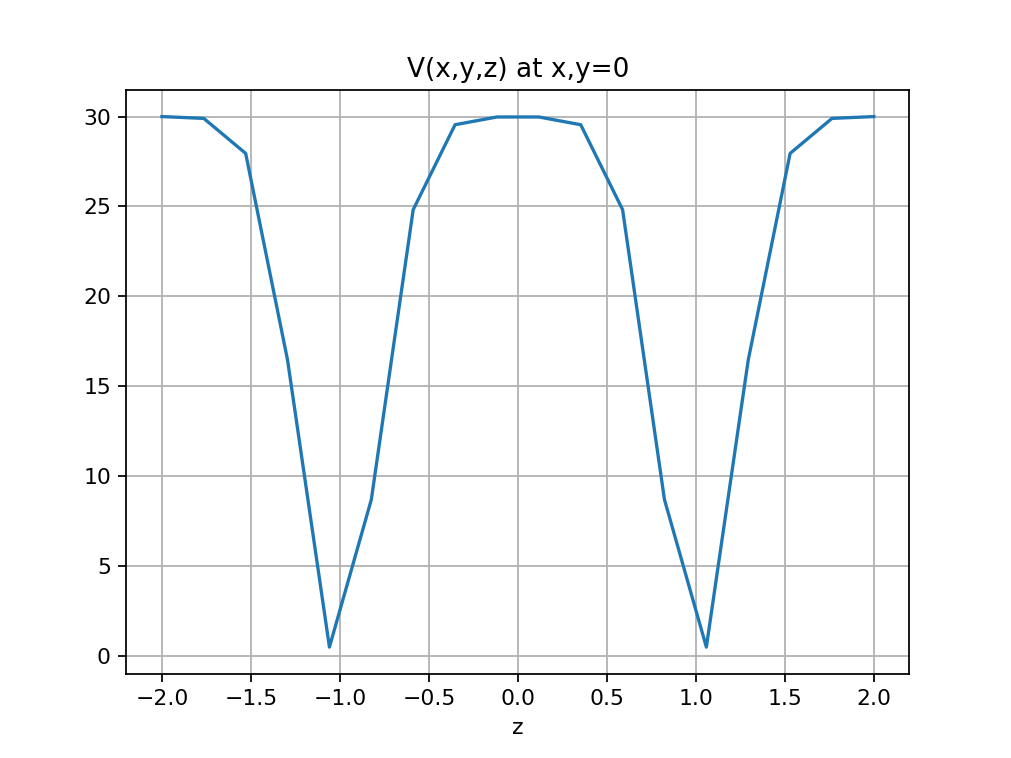

In [4]:
# This function creates a "shell" of V~0 at a specified radius, surrounded by V~V0 everywhere else
def shellpot(x,y,z,r0,V0=10):
    r2 = x**2 + y**2 + z**2
    r = np.sqrt(r2)
    sigma2 = .1
    result1 = r**.5*np.exp(-(r-r0)**2/sigma2)
    result2 = 1 - result1 / r0**.5
    result3 = result2*V0
    return result3, r

# Calculate the potential energy 
r0 = 1
ygrid,xgrid,zgrid = np.meshgrid(x,x,x) # meshgrid puts x and y in the opposite order of expected!
Vofr, r = shellpot(xgrid,ygrid,zgrid,r0,30)

# Take slices through V(r) so we're sure we made what we want
imid = int(nsteps/2)
plt.figure()
plt.plot(zgrid[imid,imid,:],Vofr[imid,imid,:],'-')
plt.title('V(x,y,z) at x,y=0')
plt.xlabel('z')
plt.grid(True)

In [5]:
# It'll be handy to define this kronecker delta function for three spatial dimensions
def kron3(X,Y,Z):
    return np.kron(X,np.kron(Y,Z))

# Matrix representation of d^2/dx^2 in the x-direction (which will be the same in y and z)
Ax =(-2.0*np.diag(np.ones(nsteps))+np.diag(np.ones(nsteps-1),1)+np.diag(np.ones(nsteps-1),-1))/dx**2

# Use the kronecker delta to assemble the kinetic energy operator over all three spatial dimensions
I = np.diag(np.ones(nsteps))
KE = -.5*(kron3(I,I,Ax) + kron3(I,Ax,I) + kron3(Ax,I,I))
print(np.shape(Ax), np.shape(KE))
print(Ax[0:4,0:4])

(18, 18) (5832, 5832)
[[-36.125   18.0625   0.       0.    ]
 [ 18.0625 -36.125   18.0625   0.    ]
 [  0.      18.0625 -36.125   18.0625]
 [  0.       0.      18.0625 -36.125 ]]


In [6]:
# Construct the matrix representation of the potential energy
A2 = Vofr; print(np.shape(A2))
A2 = np.reshape(Vofr,nsteps**3); print(np.shape(A2))
PE = np.diag(A2)

(18, 18, 18)
(5832,)


In [7]:
# Construct the Hamiltonian
H = KE + PE

In [8]:
# Diagonalize 
Epsi,psi = spla.eigh(H)

<IPython.core.display.Javascript object>


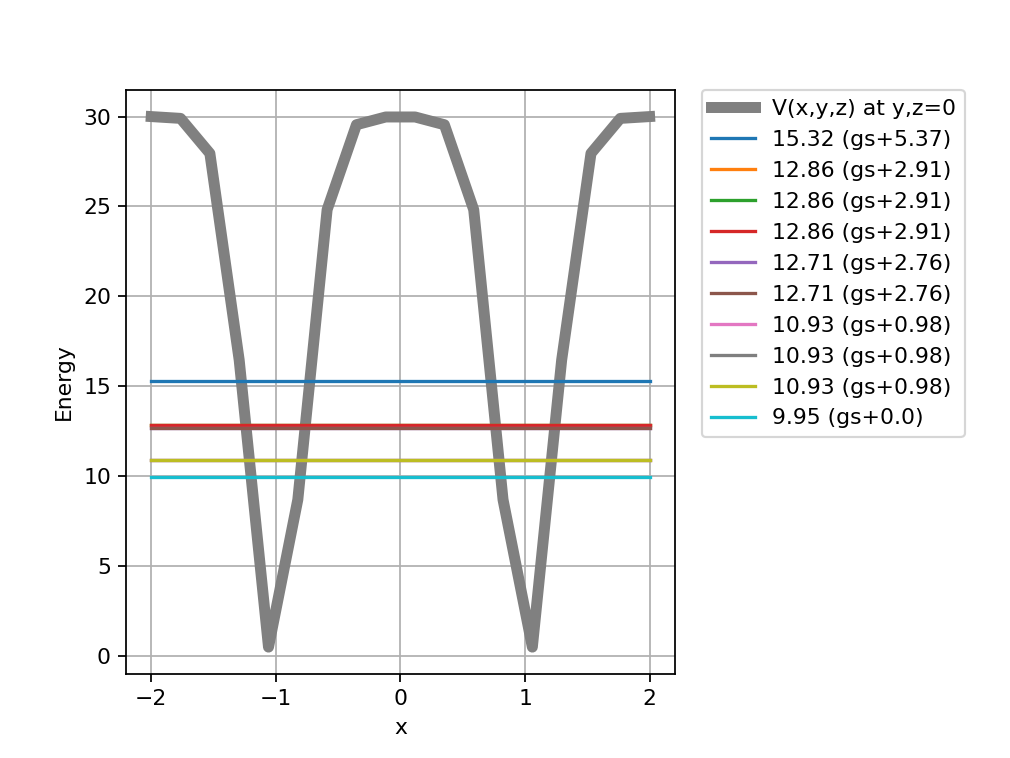

Energies & degeneracies according to https://www.physik.unibe.ch/unibe/portal/fak_naturwis/b_paw/a_fphyast/content/e41821/e41822/e140946/e148658/e875197/files902624/circle_ger.pdf
Energy =  10.0 # of states= 9
Energy =  6.0 # of states= 7
Energy =  3.0 # of states= 5
Energy =  1.0 # of states= 3
Energy =  0.0 # of states= 1


In [9]:
# Compute energy differences
Epsi_above0 = Epsi-Epsi[0]

# Visualize the energies agains the potential energy
f=plt.figure()
ax=f.add_subplot(111)

n = 10
plt.plot(x,Vofr[:,imid,imid],'gray',linewidth=5,label='V(x,y,z) at y,z=0')
for i in range(n-1,-1,-1):
    thisEnergyDifference = round(Epsi_above0[i],2)
    thisEnergy = round(Epsi[i],2)
    plt.plot( [x[0],x[-1]], [Epsi[i],Epsi[i]], label=str(thisEnergy)+' (gs+'+str(thisEnergyDifference)+')')
plt.grid('True')
plt.xlabel('x')
plt.ylabel('Energy')

# Legend on the side
L=plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
box=ax.get_position()
ax.set_position([box.x0,box.y0,0.7*box.width,box.height])

# Compare to energies and degeneracies according to an analytical approach
print('Energies & degeneracies according to https://www.physik.unibe.ch/unibe/portal/fak_naturwis/b_paw/a_fphyast/content/e41821/e41822/e140946/e148658/e875197/files902624/circle_ger.pdf')
for l in range(4,-1,-1):
    print('Energy = ', l*(l+1)/2, '# of states=', 2*l+1)

<IPython.core.display.Javascript object>


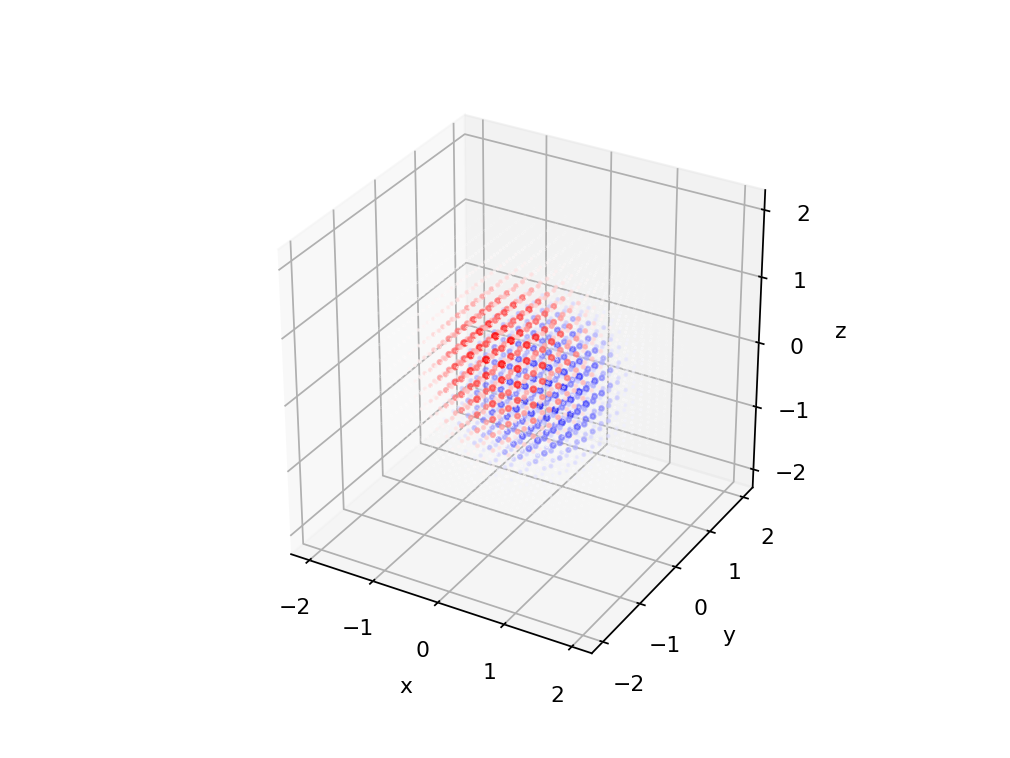

<IPython.core.display.Javascript object>


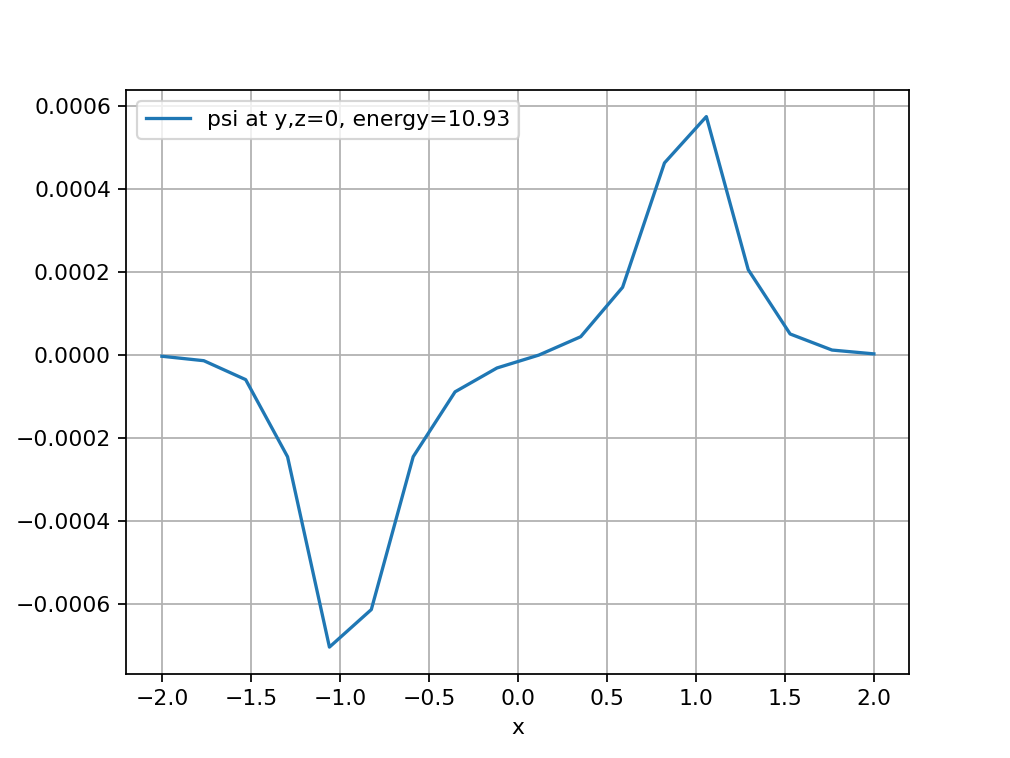

In [10]:
# Visualize a state
thisindex = 3
thispsi = psi[:,thisindex]
thisEpsi = round(Epsi[thisindex],2)
symbolsize = 100
fig = plt.figure('2,1,1')
ax = fig.add_subplot(projection='3d')
scale = np.max([np.max(thispsi),-np.min(thispsi)])
aspect_ratio = 1
ax.set_box_aspect(aspect = (aspect_ratio,1,1))
ax.scatter(xgrid,ygrid,zgrid, s=np.abs(thispsi)*symbolsize, c=np.real(thispsi), vmin=-scale, vmax=scale, cmap="bwr")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.figure()
thispsi_reshaped = np.reshape(thispsi,[nsteps,nsteps,nsteps])
plt.plot(xgrid[:,imid,imid],thispsi_reshaped[:,imid,imid],label='psi at y,z=0, energy='+str(thisEpsi))
plt.xlabel('x')
plt.grid(True)
plt.legend()

### Refreshing and saving your code
1. Use the dropdown menu Kernel/Restart
2. Use the dropdown menu Cell/Run All Above
3. Under the "File" dropdown menu item in the upper left is a disk icon. Press it now to save your work (you can, do this at any time as you're working on an assignment, actually).

### Validating
This step will help ensure that you didn't miss something (although it's not a guarantee). Find the "Validate" button and press it. If there are any errors or warnings, fix them.

### Finishing up
Assuming all this has gone smoothly, carry out three more steps (but read this carefully before starting):
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page